# Loan Prediction

## Installing packages

In [ ]:
pip install python-dotenv kaggle keras tensorflow pandas numpy scipy

## Downloading the dataset

In [1]:
# Load environment
from dotenv import load_dotenv
load_dotenv();

In [2]:
# Setup kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
# Download dataset
# The dataset belongs to a Hackathon organized by Univ.AI
api.dataset_download_files('subhamjain/loan-prediction-based-on-customer-behavior', path=".")

The downloaded zip file needs to be extracted.

In [4]:
import pandas as pd
df_train = pd.read_csv("Training Data.csv")
df_train

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251996,251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251997,251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0
251998,251999,6507128,45,0,single,rented,no,Graphic_Designer,Pondicherry,Puducherry,0,10,0


In [5]:
df_test = pd.read_csv("Test Data.csv")
df_test

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,27996,9955481,57,13,single,rented,no,Statistician,Eluru[25],Andhra Pradesh,5,10
27996,27997,2917765,47,9,single,rented,no,Technical writer,Ratlam,Madhya Pradesh,9,14
27997,27998,8082415,24,5,single,rented,no,Lawyer,Mira-Bhayandar,Maharashtra,4,13
27998,27999,9474180,51,13,single,rented,yes,Chartered Accountant,Bhilai,Chhattisgarh,13,14


In [6]:
df_pred = pd.read_csv("Sample Prediction Dataset.csv")
df_pred

,id,risk_flag
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,1
27997,27998,0
27998,27999,0


## Correlation
Testing if any feature is correlated with the labels (Risk_Flag). Some of the features have categorical data, so I looked up a way to calculate the correlation of categorical data.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [8]:
import scipy.stats as ss
import numpy as np

def cramers_v(confusion_matrix):
    """
    Source: https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
    """
    
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [9]:
categorical_data = ["Married/Single", "House_Ownership", "Car_Ownership", "Profession", "CITY", "STATE"]

corr = {}
for col_name in df_train.columns:
    if col_name in categorical_data:
        confusion_matrix = pd.crosstab(df_train[col_name], df_train["Risk_Flag"])
        corr[col_name] = abs(cramers_v(confusion_matrix.values))
    else:
        corr[col_name] = abs(df_train.corr()[col_name]["Risk_Flag"])
        
sorted(corr.items(), key=lambda x: x[1])

[('Income', 0.0030911681222762564),
 ('CURRENT_HOUSE_YRS', 0.004375163077682079),
 ('CURRENT_JOB_YRS', 0.01694158205214165),
 ('Married/Single', 0.020977357668165247),
 ('Age', 0.021809276050749886),
 ('Car_Ownership', 0.02393976513093639),
 ('House_Ownership', 0.02679951667334829),
 ('Id', 0.032153499869005515),
 ('Experience', 0.03452261289076055),
 ('Profession', 0.047287043386878704),
 ('STATE', 0.05290750721343328),
 ('CITY', 0.13954477449706917),
 ('Risk_Flag', 1.0)]

The features by themselves are not correlated with the labels.

## Preprocessing the data

In [10]:
values = dict()
for col_name in categorical_data:
    values[col_name] = pd.Categorical(df_train[col_name]).categories
values

{'Married/Single': Index(['married', 'single'], dtype='object'),
 'House_Ownership': Index(['norent_noown', 'owned', 'rented'], dtype='object'),
 'Car_Ownership': Index(['no', 'yes'], dtype='object'),
 'Profession': Index(['Air_traffic_controller', 'Analyst', 'Architect', 'Army_officer',
        'Artist', 'Aviator', 'Biomedical_Engineer', 'Chartered_Accountant',
        'Chef', 'Chemical_engineer', 'Civil_engineer', 'Civil_servant',
        'Comedian', 'Computer_hardware_engineer', 'Computer_operator',
        'Consultant', 'Dentist', 'Design_Engineer', 'Designer', 'Drafter',
        'Economist', 'Engineer', 'Fashion_Designer', 'Financial_Analyst',
        'Firefighter', 'Flight_attendant', 'Geologist', 'Graphic_Designer',
        'Hotel_Manager', 'Industrial_Engineer', 'Lawyer', 'Librarian',
        'Magistrate', 'Mechanical_engineer', 'Microbiologist', 'Official',
        'Petroleum_Engineer', 'Physician', 'Police_officer', 'Politician',
        'Psychologist', 'Scientist', 'Secretar

In [11]:
def preprocess(df):
    df_clean = df
    
    # removing features with categorical data, row ids and the labels
    drop_filter = ["CITY", "STATE", "Profession", "Id", "ID", "Risk_Flag"]
    
    for col_name in drop_filter:
        if col_name in df.columns:
            df_clean = df_clean.drop(columns=col_name)
    
    df_clean["Married/Single"] = df_clean["Married/Single"].apply(lambda status: 1 if status == "married" else 0)
    
    ownership_to_id = {"owned": 1, "rented": 0, "norent_noown": -1}
    df_clean["House_Ownership"] = df_clean["House_Ownership"].apply(lambda ownership: ownership_to_id[ownership])
    
    df_clean["Car_Ownership"] = df_clean["Car_Ownership"].apply(lambda ownership: 1 if ownership == "yes" else 0)
    
    return df_clean

In [12]:
x_train = preprocess(df_train)
x_train

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1303834,23,3,0,0,0,3,13
1,7574516,40,10,0,0,0,9,13
2,3991815,66,4,1,0,0,4,10
3,6256451,41,2,0,0,1,2,12
4,5768871,47,11,0,0,0,3,14
...,...,...,...,...,...,...,...,...
251995,8154883,43,13,0,0,0,6,11
251996,2843572,26,10,0,0,0,6,11
251997,4522448,46,7,0,0,0,7,12
251998,6507128,45,0,0,0,0,0,10


In [13]:
x_test = preprocess(df_test)
x_test

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,7393090,59,19,0,0,0,4,13
1,1215004,25,5,0,0,0,5,10
2,8901342,50,12,0,0,0,9,14
3,1944421,49,9,1,0,1,3,12
4,13429,25,18,0,0,1,13,11
...,...,...,...,...,...,...,...,...
27995,9955481,57,13,0,0,0,5,10
27996,2917765,47,9,0,0,0,9,14
27997,8082415,24,5,0,0,0,4,13
27998,9474180,51,13,0,0,1,13,14


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
import keras

In [15]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [16]:
y_train = df_train["Risk_Flag"]
y_test = df_pred["risk_flag"]

## Machine Learning Models

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
logreg = LogisticRegression(random_state=3754, multi_class='multinomial')
logreg.fit(x_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=3754)

In [19]:
y_pred = logreg.predict(x_test)

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
accuracy_score(y_test, y_pred)

0.8716785714285714

<AxesSubplot:>

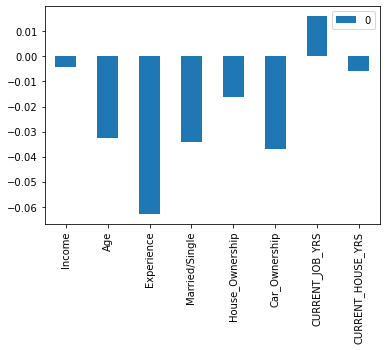

In [22]:
feat_names = ["Income", "Age", "Experience", "Married/Single", "House_Ownership", "Car_Ownership", "CURRENT_JOB_YRS", "CURRENT_HOUSE_YRS"]
coefs_df = pd.DataFrame(logreg.coef_, columns=feat_names)
coefs_df.T.plot.bar()

### Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
accuracy_score(y_test, y_pred)

0.7701428571428571

In [25]:
tree = DecisionTreeClassifier(criterion="entropy")
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
accuracy_score(y_test, y_pred)

0.7719642857142858

### Random Forest

In [26]:
from sklearn.tree import plot_tree

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3512)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)

0.8716785714285714

<AxesSubplot:>

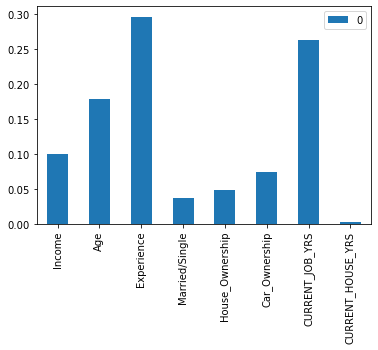

In [29]:
feat_names = ["Income", "Age", "Experience", "Married/Single", "House_Ownership", "Car_Ownership", "CURRENT_JOB_YRS", "CURRENT_HOUSE_YRS"]
coefs_df = pd.DataFrame([rf.feature_importances_], columns=feat_names)
coefs_df.T.plot.bar()

### Neural Network

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [31]:
y_train

0         0
1         0
2         0
3         1
4         1
         ..
251995    0
251996    0
251997    0
251998    0
251999    0
Name: Risk_Flag, Length: 252000, dtype: int64

In [32]:
y_train_cat = to_categorical(y_train)

In [33]:
model = Sequential()
model.add(Dense(units=2, activation="relu", input_shape=x_train.shape[1:]))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 18        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [34]:
h = model.fit(x_train, y_train_cat, epochs=1, validation_split=0.2, batch_size=100)

2016/2016 [==============================] - 9s 4ms/step - loss: nan - accuracy: 0.8923 - val_loss: nan - val_accuracy: 0.8153


In [35]:
y_pred = np.argmax(model.predict(x_test), axis=1)

In [36]:
accuracy_score(y_test, y_pred)

0.8716785714285714

## Summary
Logistic Regression, Random Forest and Neural Network models got the same accuracy score, around 87%. This is possibly an optimum with the data provided (without categorical data).